In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report
from xgboost import XGBClassifier
pd.set_option('display.max_columns', 100)
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

# Data Parsing & EDA:

In [2]:
# Loading the data:
csv_path = '../train.csv'
df = pd.read_csv(csv_path)
df_backup = df.copy(deep=True)
# looking at the data and determining parsing actions:
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [3]:
# exploring unique categories inside the df
for i in df.columns:
    print (i)
    print(df[i].unique())
    print('_______________________')

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
_______________________
job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
_______________________
marital
['married' 'single' 'divorced']
_______________________
education
['tertiary' 'secondary' 'unknown' 'primary']
_______________________
default
['no' 'yes']
_______________________
balance
[ 2143    29     2 ...  8205 14204 16353]
_______________________
housing
['yes' 'no']
_______________________
loan
['no' 'yes']
_______________________
contact
['unknown' 'cellular' 'telephone']
_______________________
day
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
_______________________
month
['may' 'jun'

In [4]:
# determining the number of unique categories
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [5]:
# finding missing values if any
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
numerical_cols = df.select_dtypes(exclude=object).columns
categorical_cols = df.select_dtypes(include=object).columns

In [7]:
# Determining number of unknowns and suitable actions:
for col in categorical_cols:
    unknowns = df[df[col]=='unknown']
    n_vals = unknowns[col].value_counts().sum()
    percentage = n_vals * 100 / len(df)
    print(f"Column {col} has {n_vals} unknowns, which are {percentage:.2f}% of the dataset")
# In the column pdays, -1 means not previously contacted
n_vals_pdays = df[df['pdays']==-1].value_counts().sum()
percentage_pdays = n_vals_pdays * 100 / len(df)
print(f"Column pdays has {n_vals_pdays} unknowns, which are {percentage_pdays:.2f}% of the dataset")

Column job has 288 unknowns, which are 0.64% of the dataset
Column marital has 0 unknowns, which are 0.00% of the dataset
Column education has 1857 unknowns, which are 4.11% of the dataset
Column default has 0 unknowns, which are 0.00% of the dataset
Column housing has 0 unknowns, which are 0.00% of the dataset
Column loan has 0 unknowns, which are 0.00% of the dataset
Column contact has 13020 unknowns, which are 28.80% of the dataset
Column month has 0 unknowns, which are 0.00% of the dataset
Column poutcome has 36959 unknowns, which are 81.75% of the dataset
Column y has 0 unknowns, which are 0.00% of the dataset
Column pdays has 36954 unknowns, which are 81.74% of the dataset


Parsing steps:
+ 1- y: rename to subscribed, onehot encode. 
+ 2- job, marital, default, housing, load, loan, month, contact, poutcome, education, y: one-hot encode.
+ 3- leave unknowns as they are, as the columns aren't predictive of each other, and the unknown will act like an average.
+ 4- Engineer a new feature: average_income (monthly)
where:

    - Management: The average salary for a management position in Portugal is €3500 per month.
    - Entrepreneur: €2500 per month
    - Technician: The average salary for a technician in Portugal is €2,647 per month
    - Services (e.g., programmer, engineer, teacher, office manager, courier, driver, waiter): €2000 per month.
    - Self-employed: We will assume he will have the average salary in Portugal, which is €1800
    - Unknown: We will assume he will have the average salary in Portugal, which is €1800.
    - Blue-collar: The average salary for a blue-collar worker in Portugal is between €1400 per month.
    - Admin: The average salary for an administrative assistant in Portugal is €1200 per month.
    - Housemaid: €1000
    - Student: €300
    - Unemployed: €0
    - Retired: €0


In [8]:
# New feature: avg_salary
job_ranks_dict = {'management': 3500, 'technician': 2674, 'entrepreneur': 2500, 'blue-collar':1400, 'unknown':1800,
 'retired': 0, 'admin.': 1200, 'services': 2000, 'self-employed':1800, 'unemployed':0, 'housemaid': 1000,
 'student': 300}
df['avg_salary'] = df['job'].map(job_ranks_dict)

In [9]:
df.rename(columns={'y': 'subbed'}, inplace=True)

In [10]:
# Reselecting
numerical_cols = df.select_dtypes(exclude=object).columns
categorical_cols = df.select_dtypes(include=object).columns
print(numerical_cols)
print(categorical_cols)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'avg_salary'],
      dtype='object')
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'subbed'],
      dtype='object')


In [11]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,avg_salary
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,1994.091659
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,1053.829521
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,1400.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,2000.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,2674.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,3500.000000


In [12]:
df[numerical_cols].corr()

,age,balance,day,duration,campaign,pdays,previous,avg_salary
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,-0.158308
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.030460
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,0.035728
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,-0.020228
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,0.040766
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,-0.014580
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.008384
avg_salary,-0.158308,0.030460,0.035728,-0.020228,0.040766,-0.014580,0.008384,1.000000


Nothing stands out for feature correlation except a bit of correlation between  day: last contact day of the month (numeric) and  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact). Which means next to nothing. Salary inversely correlates with age a bit.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'avg_salary'}>, <Axes: >]], dtype=object)

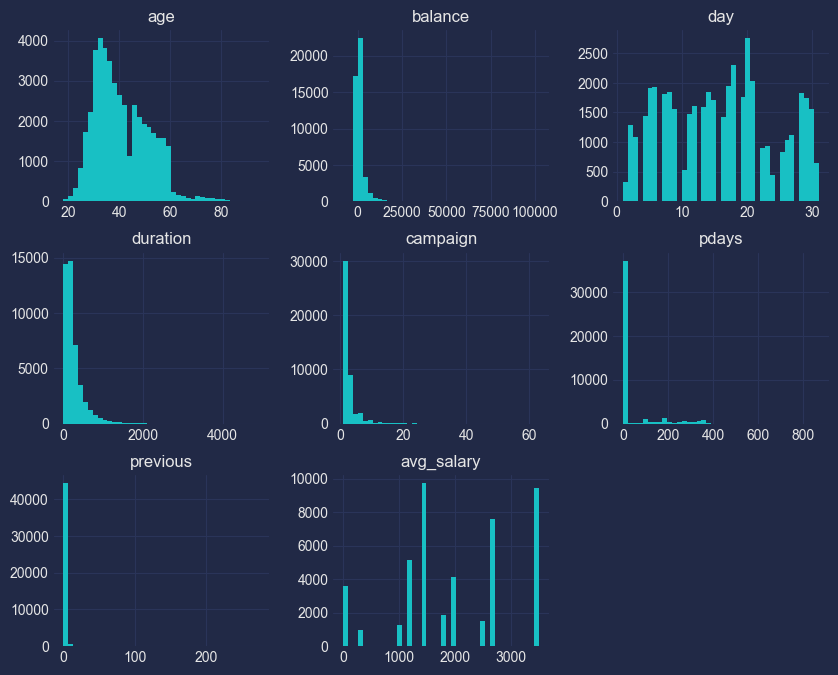

In [13]:
# getting a feel for the data distribution over the numerical features
df.hist(bins=40, figsize=(10,8))

Apparently, balance, campaign, and duration columns need to be transformed to be in a Gaussian distribution.

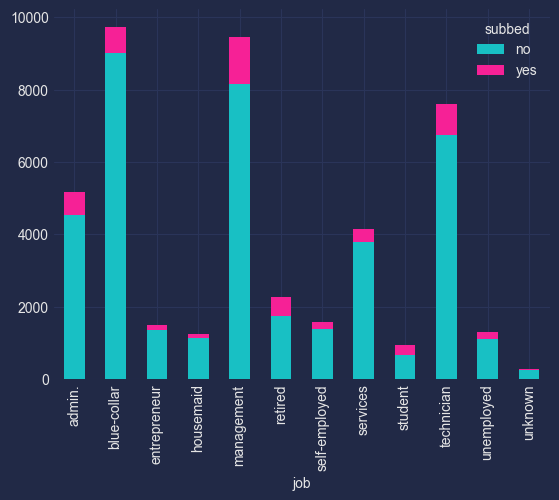

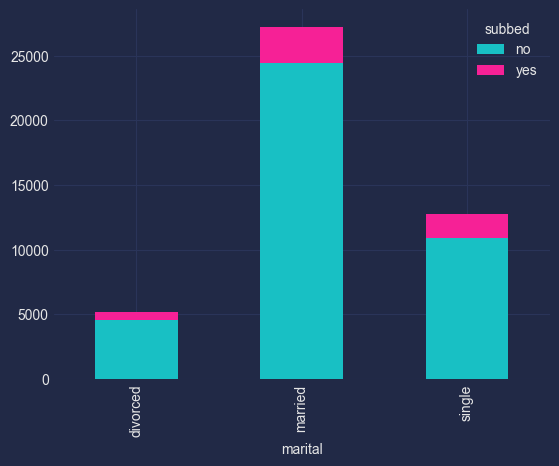

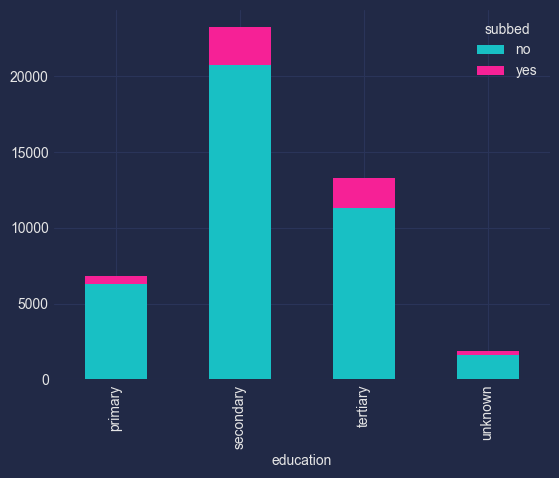

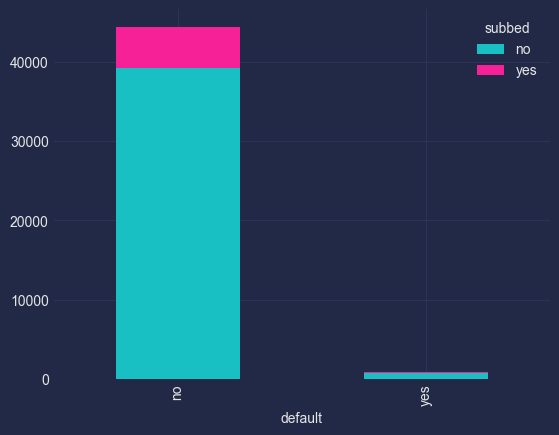

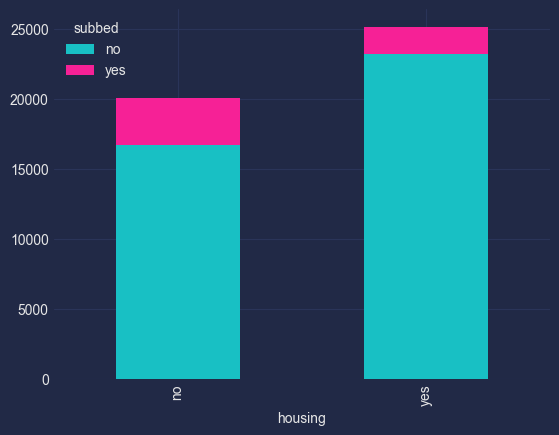

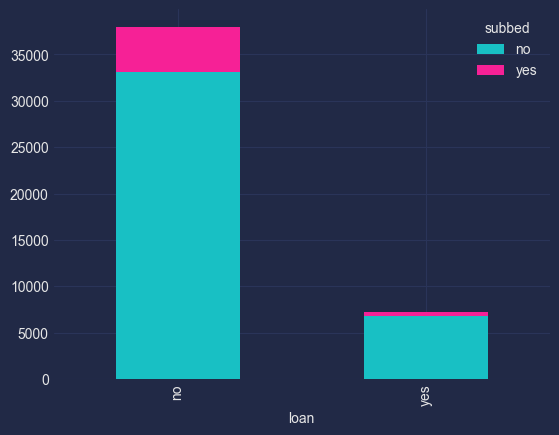

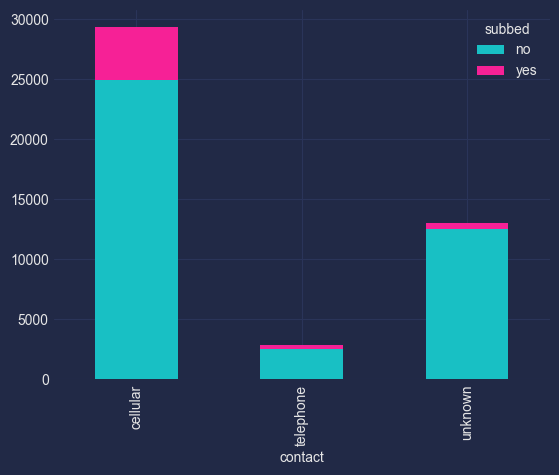

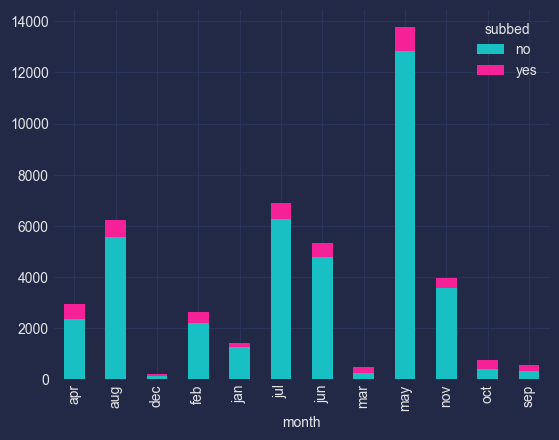

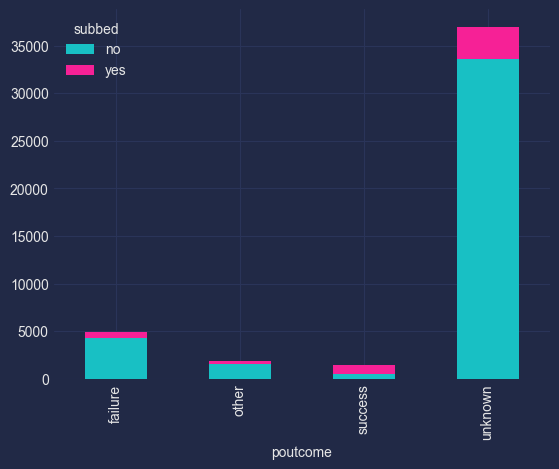

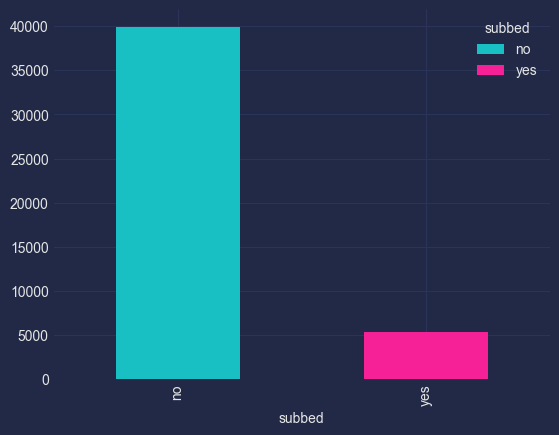

In [14]:
# Plotting every categorical feature's distribution against the target feature
for cat_col in categorical_cols:
    pd.crosstab(df[cat_col], df['subbed']).plot(kind='bar', stacked=True)
    plt.show()

- It doesn't seem like some jobs have higher percentage of subscriptions than others. It seems that housemaids and self employed in particular aren't likely to subscribe.
- Martial status, month, and education doesn't look to affect the subscription outcome so much.
- It's very unlikely for someone who defaulted on a previous loan to subscribe to a loan.
- People who don't have a house loan are more likely to subscribe.
- People who got contacted by cellular are more likely to subscribe.
- People who's the previous outcome of the marketing campaign on them was successfull are more likely to subscribe than others.

<Axes: >

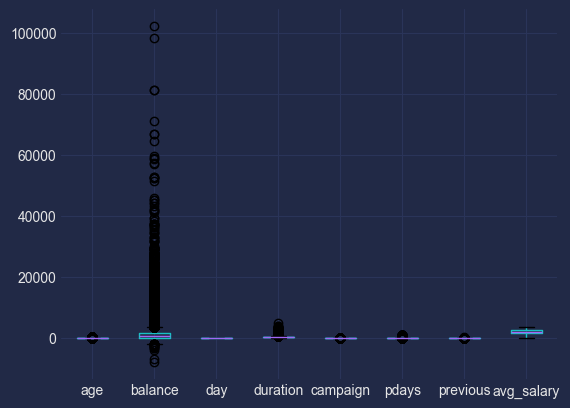

In [15]:
# Detecting outliers
df.boxplot()

Seems like a lot of outliers, especially for the balance column. We may want to clean them.

# Data Modeling:

In [16]:
# Removing outliers using IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
iqr = Q3 - Q1
upper_limit = Q3 + iqr * 1.5
lower_limit = Q1 - iqr * 1.5
df_no_outliers = df[(df['balance'] > lower_limit) & (df['balance'] < upper_limit)]

In [17]:
# Counting the number of outliers removed
print(len(df)-len(df_no_outliers))

4731


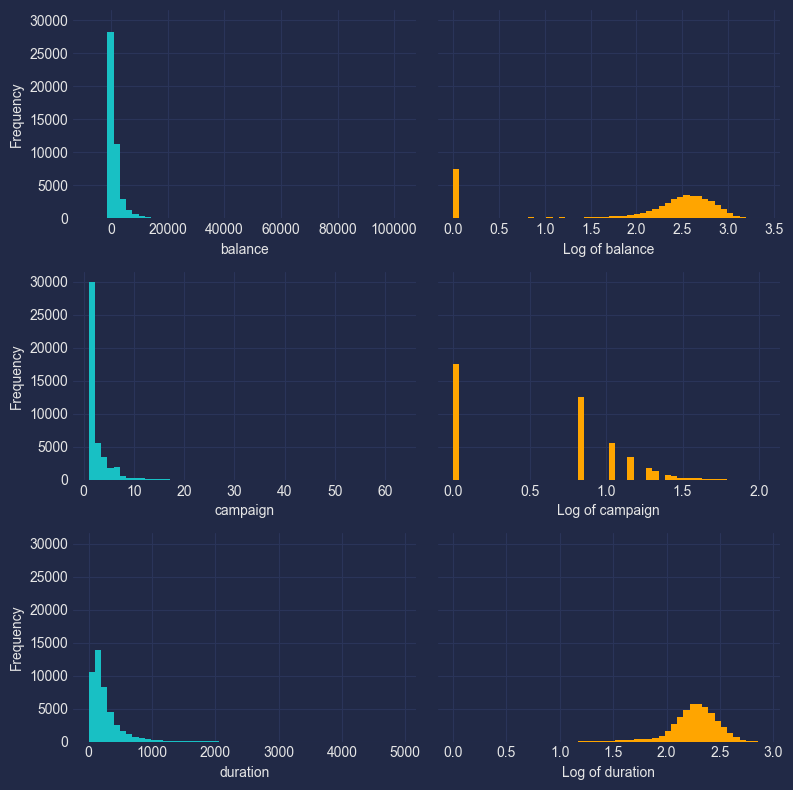

In [18]:
# Demoing the log-transformation
log_cols = ['balance', 'campaign', 'duration']
fig, axs = plt.subplots(len(log_cols), 2, figsize=(8, 8), sharey=True)
for i, col in enumerate(log_cols):
    df[col].hist(ax=axs[i, 0], bins=50)
    df[col].apply(lambda x: np.sqrt(np.log(x)) if x > 0 else 0).hist(ax=axs[i, 1], bins=50, color='orange')
    axs[i, 0].set_xlabel(log_cols[i])
    axs[i, 1].set_xlabel("Log of " + log_cols[i])
    axs[i, 0].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [19]:
df[df['balance']<0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subbed,avg_salary
25,44,admin.,married,secondary,no,-372,yes,no,unknown,5,may,172,1,-1,0,unknown,no,1200
28,46,management,single,secondary,no,-246,yes,no,unknown,5,may,255,2,-1,0,unknown,no,3500
36,25,blue-collar,married,secondary,no,-7,yes,no,unknown,5,may,365,1,-1,0,unknown,no,1400
37,53,technician,married,secondary,no,-3,no,no,unknown,5,may,1666,1,-1,0,unknown,no,2674
45,36,admin.,single,primary,no,-171,yes,no,unknown,5,may,242,1,-1,0,unknown,no,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44626,31,services,single,secondary,no,-205,no,no,cellular,1,sep,481,1,579,1,failure,yes,2000
44629,28,blue-collar,single,secondary,no,-46,yes,no,cellular,1,sep,199,1,92,14,success,yes,1400
44836,33,blue-collar,married,primary,no,-195,no,no,unknown,20,sep,9,1,-1,0,unknown,no,1400
44908,48,management,divorced,tertiary,no,-130,yes,no,cellular,29,sep,110,2,61,9,failure,no,3500


In [20]:
# Transformation pipelines

# Encoding the target column
df['subbed'] = df['subbed'].map(lambda x: 0 if x=='no' else 1)

log_cols = ['balance', 'campaign', 'duration']
# Define a custom function that adds a small constant before taking the log
def log_transform(X):
    # Add a constant to avoid log(0)
    X_shifted = X + 1e-8
    # Apply log to absolute values and then reintroduce the sign
    return np.sign(X) * np.log(np.abs(X_shifted))

log_pipeline = make_pipeline(
    FunctionTransformer(func=log_transform, validate=False, feature_names_out='one-to-one')
)

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

ordinal_pipeline = make_pipeline(
    OrdinalEncoder(categories=[['unknown', 'primary', 'secondary', 'tertiary']])
)

num_pipeline = make_pipeline(
    StandardScaler()
)

cat_col

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_exclude=object)),
    (cat_pipeline, ['job', 'marital', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome']),
    (ordinal_pipeline, ['education']),
    (log_pipeline, log_cols)
)



In [21]:
df_prepared = preprocessing.fit_transform(df)
df_prepared.shape

(45211, 53)

In [22]:
# Train-test-split
X = df.drop(['subbed'], axis=1)
y = df['subbed']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In this problem, we prefer the recall over the precision. A subscriber is worth more than lost resources of marketing and calls. We don't want to filter out many potential subscribers. We can sacrifice some precision, but not much either so that we don't waste bank marketing resources. 

SGD Classifer:
 Accuracy: 0.8936193741015149 ROC score: 0.8900617269151112
 Classification Report for SGD Classifer:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7952
           1       0.57      0.47      0.52      1091

    accuracy                           0.89      9043
   macro avg       0.75      0.71      0.73      9043
weighted avg       0.89      0.89      0.89      9043


Logistic Regression:
 Accuracy: 0.8998120092889528 ROC score: 0.9025267553994915
 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7952
           1       0.66      0.36      0.46      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.67      0.70      9043
weighted avg       0.89      0.90      0.89      9043


KNeighbors Classifier:
 Accuracy: 0.885989162888422 ROC score: 0.8025977242925934
 Classification 

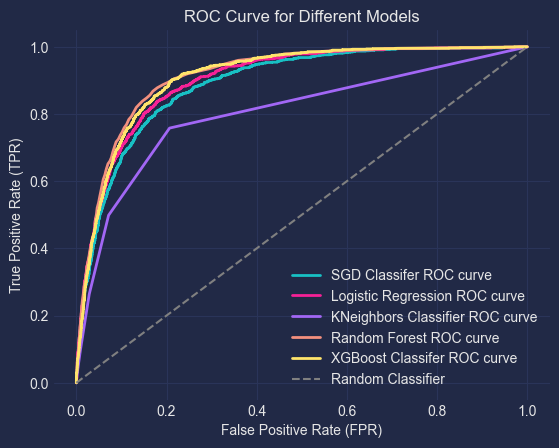

Best model is: Random Forest


In [23]:
# Training
threshold = 0.5
models = {
    'SGD Classifer': SGDClassifier(loss='log_loss'),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost Classifer': XGBClassifier(),
}

best_model_name = ""
best_roc_score = 0

for name, model in models.items():
    model_pipeline = make_pipeline(preprocessing, model)
    model_pipeline.fit(X_train, y_train)
    y_scores = cross_val_predict(model_pipeline, X_val, y_val, cv=3, method="predict_proba")[:, 1]
    y_pred_binary = (y_scores > threshold).astype(int)
    acc = accuracy_score(y_val, y_pred_binary)
    roc_score = roc_auc_score(y_val, y_scores)
    report = classification_report(y_val, y_pred_binary)
    print(f"{name}:\n",
        f"Accuracy: {acc}",
        f"ROC score: {roc_score}\n",
        f"Classification Report for {name}:\n{report}\n",
        "=" * 30 + "\n"
    )
    
    # Plot ROC curve for the model
    fpr, tpr, thresholds = roc_curve(y_val, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} ROC curve')
    
    if roc_score > best_roc_score:
        best_roc_score = roc_score
        best_model_name = name

# Plot the random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Different Models')
plt.legend()
plt.show()

print(f"Best model is: {best_model_name}")

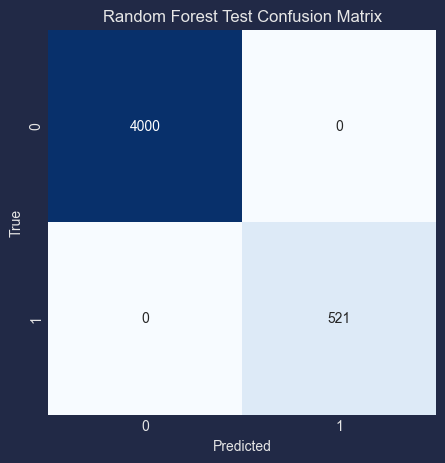

In [25]:
# Inference and testing of the best model on the test set
df_test = pd.read_csv("../test.csv")
df_test.rename(columns={'y': 'subbed'}, inplace=True)

# Encoding the target column
df_test['subbed'] = df_test['subbed'].map(lambda x: 0 if x=='no' else 1)

# Adding the avg_salary feature
df_test['avg_salary'] = df_test['job'].map(job_ranks_dict)

X_test = df_test.drop('subbed', axis=1)
y_test = df_test['subbed']

# Training best performing model
rf_clf = RandomForestClassifier()
model_pipeline = make_pipeline(preprocessing, rf_clf)
model_pipeline.fit(X, y) # Fitting the full training dataset for the final model
y_scores = model_pipeline.predict(X_test)
rf_cm = confusion_matrix(y_scores, y_test)
rf_clf_rep = classification_report(y_scores, y_test)
plt.figure(figsize=(5,5))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forest Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [27]:
print(rf_clf_rep)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521



Seems like we have achieved perfection. It might be too good to be true, a mistake on my end. I double checked, couldn't notice what's wrong. Maybe the test data is repeated between the training set and the test set. Let's check for that. 

In [28]:
# Read the CSV files into DataFrames
df1 = pd.read_csv('../train.csv')
df2 = pd.read_csv('../test.csv')

# Check if entire rows match between df1 and df2
merged_df = pd.merge(df1, df2, how='outer', indicator=True)

# Filter rows where both DataFrames have the same values (exist in both)
matching_rows = merged_df[merged_df['_merge'] == 'both']

# Display or save the matching rows
print(matching_rows)

       age           job   marital  education default  balance housing loan  \
7       42  entrepreneur  divorced   tertiary     yes        2     yes   no   
9       43    technician    single  secondary      no      593     yes   no   
14      57      services   married  secondary      no      162     yes   no   
30      57    technician   married  secondary      no      839      no  yes   
33      59   blue-collar   married  secondary      no        0     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45160   35    technician   married  secondary      no        0     yes   no   
45173   36        admin.    single   tertiary      no      980      no   no   
45191   75       retired  divorced   tertiary      no     3810     yes   no   
45197   36    management    single  secondary      no     1511     yes   no   
45205   25    technician    single  secondary      no      505      no  yes   

        contact  day month  duration  campaign  pda

Yes, indeed. Unfortunately the dataset test set is flawed. All the data inside it is repeated from the training data. Let's remove them from the training data, retrain on the training data and then predict again on the test set.

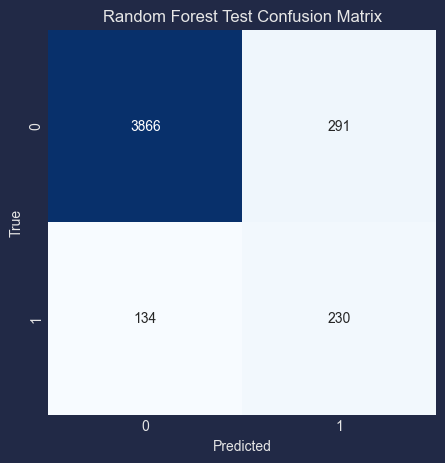

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4157
           1       0.44      0.63      0.52       364

    accuracy                           0.91      4521
   macro avg       0.70      0.78      0.73      4521
weighted avg       0.92      0.91      0.91      4521



In [43]:
filtered_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
df2 = pd.read_csv('../test.csv')

filtered_df.rename(columns={'y': 'subbed'}, inplace=True)
df2.rename(columns={'y': 'subbed'}, inplace=True)

# Encoding the target column
filtered_df['subbed'] = filtered_df['subbed'].map(lambda x: 0 if x=='no' else 1)
df2['subbed'] = df2['subbed'].map(lambda x: 0 if x=='no' else 1)

# Adding the avg_salary feature
filtered_df['avg_salary'] =filtered_df['job'].map(job_ranks_dict)
df2['avg_salary'] =df2['job'].map(job_ranks_dict)

X = filtered_df.drop('subbed', axis=1)
y = filtered_df['subbed']

X_test = df2.drop('subbed', axis=1)
y_test = df2['subbed']

# Training best performing model
rf_clf = RandomForestClassifier()
model_pipeline = make_pipeline(preprocessing, rf_clf)
model_pipeline.fit(X, y) # Fitting the full training dataset for the final model
y_scores = model_pipeline.predict(X_test)
rf_cm = confusion_matrix(y_scores, y_test)
rf_clf_rep = classification_report(y_scores, y_test)
plt.figure(figsize=(5,5))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forest Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print(rf_clf_rep)

The best model is Random Forest, with an F-1 score of 0.52. One possible improvement is to fine-tune the model using cross-validation and grid-search.
We also could pick a different threshold, where we would not have as many true negatives (134), but have more false positives (291). This is due to the reason we mentioned earlier: marketing resources aren't more valuable than a subscribing customer. We would rather have more calls to people who wouldn't subsribe, than not calling people who would.